In [13]:
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPModel
import torch

In [4]:
imagenette = load_dataset(
    'frgfm/imagenette',
    '320px',
    split='validation',
    revision="4d512db"
)

imagenette

Dataset({
    features: ['image', 'label'],
    num_rows: 3925
})

In [5]:
set(imagenette['label'])
labels = imagenette.info.features['label'].names
labels

['tench',
 'English springer',
 'cassette player',
 'chain saw',
 'church',
 'French horn',
 'garbage truck',
 'gas pump',
 'golf ball',
 'parachute']

In [6]:
clip_labels = [f"a photo of a {label}" for label in labels]
clip_labels

['a photo of a tench',
 'a photo of a English springer',
 'a photo of a cassette player',
 'a photo of a chain saw',
 'a photo of a church',
 'a photo of a French horn',
 'a photo of a garbage truck',
 'a photo of a gas pump',
 'a photo of a golf ball',
 'a photo of a parachute']

In [11]:
model_id = "openai/clip-vit-base-patch32"

processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id)

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# move the model to the device
model.to(device)

device

'cuda'

In [15]:
label_tokens = processor(
    text=clip_labels,
    padding=True,
    images=None,
    return_tensors='pt'
).to(device)

label_tokens['input_ids'][0][:10]

tensor([49406,   320,  1125,   539,   320,  1149,   634, 49407],
       device='cuda:0')

In [16]:
# encode tokens to sentence embeddings
label_emb = model.get_text_features(**label_tokens)
# detach from pytorch gradient computation
label_emb = label_emb.detach().cpu().numpy()
label_emb.shape

(10, 512)

In [17]:
label_emb.min(), label_emb.max()

(-1.9079261, 6.171629)

In [18]:
import numpy as np

# normalization
label_emb = label_emb / np.linalg.norm(label_emb, axis=0)
label_emb.min(), label_emb.max()

(-0.8760549, 0.8961743)

In [21]:
imagenette.shape

(3925, 2)

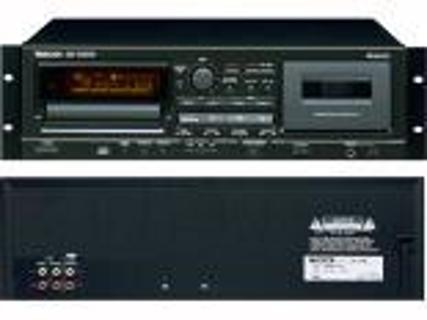

In [30]:
imagenette[17]['image']

In [31]:
image = processor(
    text=None,
    images=imagenette[0]['image'],
    return_tensors='pt'
)['pixel_values'].to(device)
image.shape

torch.Size([1, 3, 224, 224])

In [32]:
img_emb = model.get_image_features(image)
img_emb.shape

torch.Size([1, 512])

In [33]:
img_emb = img_emb.detach().cpu().numpy()

In [34]:
scores = np.dot(img_emb, label_emb.T)
scores.shape

(1, 10)

In [35]:
pred = np.argmax(scores)
pred

2

In [36]:
labels[pred]

'cassette player'

In [37]:
from tqdm.auto import tqdm

preds = []
batch_size = 32

for i in tqdm(range(0, len(imagenette), batch_size)):
    i_end = min(i + batch_size, len(imagenette))
    images = processor(
        text=None,
        images=imagenette[i:i_end]['image'],
        return_tensors='pt'
    )['pixel_values'].to(device)
    img_emb = model.get_image_features(images)
    img_emb = img_emb.detach().cpu().numpy()
    scores = np.dot(img_emb, label_emb.T)
    preds.extend(np.argmax(scores, axis=1))

100%|██████████| 123/123 [00:43<00:00,  2.83it/s]


In [38]:
true_preds = []
for i, label in enumerate(imagenette['label']):
    if label == preds[i]:
        true_preds.append(1)
    else:
        true_preds.append(0)

sum(true_preds) / len(true_preds)

0.9870063694267516